# 6. Time Evolution

In [1]:
import numpy as np

from scipy.fft import fft2, ifft2

import matplotlib.pyplot as plt

In [2]:
Nx = 60
Ny = 40

x_grid = np.linspace(- np.pi, np.pi, Nx + 1)[:-1, None]
y_grid = np.linspace(- np.pi, np.pi, Ny + 1)[:-1, None]
x_sq = x_grid @ np.ones((1, Ny))
y_sq = np.ones((Nx, 1)) @ y_grid.T

def aliased_index(k, N):
    return k - N * (k >= (N + 1)//2)

wx_sq = aliased_index(np.arange(Nx)[:, None], Nx) @ np.ones((1, Ny))
wy_sq = np.ones((Nx, 1)) @ aliased_index(np.arange(Ny)[None, :], Ny)

# wx_sq[Nx//2, :] = 0    # We only need  to kill the Nyquist mode for odd derivatives.
# wy_sq[:, Ny//2] = 0    # This is equivalent to Trefethen's trick in page 23.

In [3]:
def rhs(t, X):
    FFT_d2xX = ifft2(- wx_sq**2 * fft2(X[:, :, 0])).real
    FFT_d2yX = ifft2(- wy_sq**2 * fft2(X[:, :, 0])).real
    
    dtX = np.zeros((Nx, Ny, 2))    
    dtX[:, :, 0] = X[:, :, 1]
    dtX[:, :, 1] = FFT_d2xX + FFT_d2yX

    return dtX

def RK4(t, X):
    k1 = rhs(t, X)
    k2 = rhs(t + 0.5 * dt, X + 0.5 * k1 * dt)
    k3 = rhs(t + 0.5 * dt, X + 0.5 * k2 * dt)
    k4 = rhs(t + dt, X + k3 * dt)
    return t + dt, X + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

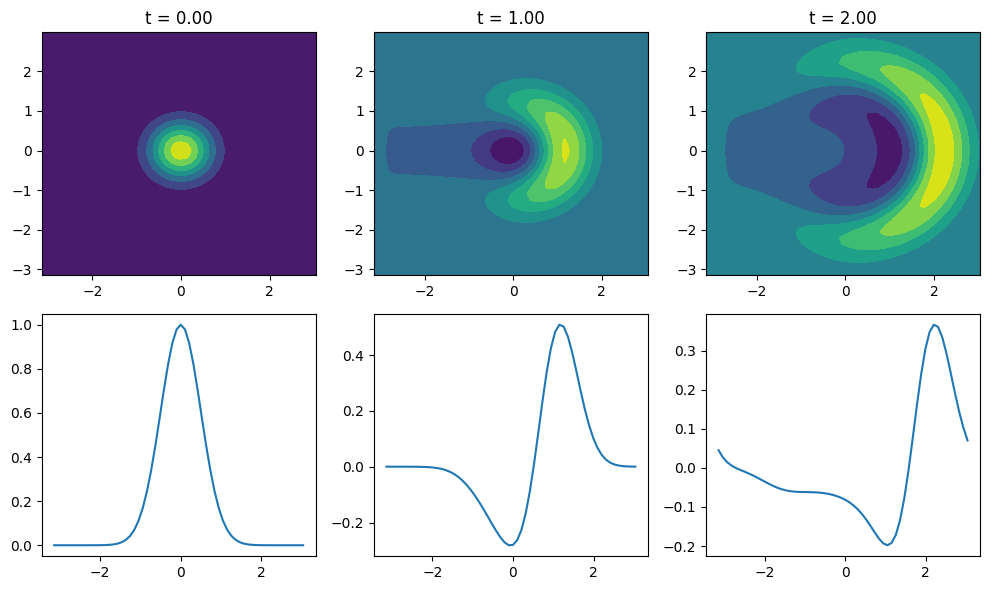

In [4]:
X = np.zeros((Nx, Ny, 2))    # Set initial conditions
X[:, :, 0] = np.exp(- 2 * (x_sq**2 + y_sq**2))
X[:, :, 1] = 4 * x_sq * np.exp(- 2 * (x_sq**2 + y_sq**2))

t = 0
dt = 0.1

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(2, 3, figsize = (10, 6));
plt.rc('font', size = 10)

for i in range(21):
    rt = int(np.round(t))
    if np.abs(rt - t) < 1e-6:
        ax[0, rt].set_title(f't = {t:.2f}')
        ax[0, rt].contourf(x_sq, y_sq, X[:,:,0])
        ax[1, rt].plot(x_grid, X[:, Ny//2, 0])
    t, X = RK4(t, X)
        
plt.tight_layout()
################################################################################